In [11]:
import numpy as np
import os
from query.models import Frame
from scannerpy import Database, DeviceType, Job, BulkJob, ColumnType
%matplotlib inline

In [8]:
mkdir videos

mkdir: cannot create directory 'videos': File exists


In [2]:
cp gcs/videos/jackson-town-square.mp4 videos

^C


In [3]:
from IPython.display import HTML

def view_video(relative_path, width=320, height=240):
    return HTML(data='''
    <video width="%d" height="%d" controls>
        <source src="./%s" type="video/mp4">
    </video>''' % (width, height, relative_path))

In [14]:
def gather_frames(frame_ids, video_path, load_video_from_scratch=True):
    with Database() as db:
        if not db.has_table('target_video') or load_video_from_scratch:
            db.ingest_videos([('target_video', video_path)], force=True)
        frame = db.ops.FrameInput()
        sampled_frames = frame.sample()
        output_op = db.ops.Output(columns=[sampled_frames])
        job = Job(
            op_args={
                frame: db.table('target_video').column('frame'),
                sampled_frames: db.sampler.gather([i for i in frame_ids]),
                output_op: 'matching_frames'
            }
        )
        bulk_job = BulkJob(output_op, [job])
        [output] = db.run(bulk_job, force=True)
        frames = [f[1][:, :, ::-1] for f in output.column('frame').load()]
        return frames

def gather_frames_into_video(frame_ids, video_path, output_path, load_video_from_scratch=True):
    with Database() as db:
        if not db.has_table('target_video') or load_video_from_scratch:
            db.ingest_videos([('target_video', video_path)], force=True)
        frame = db.ops.FrameInput()
        sampled_frames = frame.sample()
        output_op = db.ops.Output(columns=[sampled_frames])
        job = Job(
            op_args={
                frame: db.table('target_video').column('frame'),
                sampled_frames: db.sampler.gather([i for i in frame_ids]),
                output_op: 'matching_frames'
            }
        )
        bulk_job = BulkJob(output_op, [job])
        [output] = db.run(bulk_job, force=True)
        output_path = os.path.splitext(output_path)[0]
        output.column('frame').save_mp4(output_path)

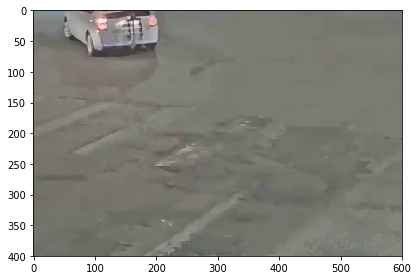

In [37]:
img = gather_frames([0], 'videos/jackson-town-square.mp4', load_video_from_scratch=False)
skio.imshow(img[0])

In [5]:
present_labeled_frame_ids = \
    Frame.objects.filter(video__path='videos/jackson-town-square.mp4',
                         label__source__name='Viscloud Labeler',
                         label__category__name='person',
                         label__presence__name='PRESENT').order_by('number').values_list('number', flat=True)
present_labeled_frame_ids = list(present_labeled_frame_ids)

In [46]:
mkdir scanner_videos

In [49]:
output_path = 'scanner_videos/jackson-hand-labels-present.mp4'
gather_frames_into_video(present_labeled_frame_ids, 'videos/jackson-town-square.mp4',
                         output_path, load_video_from_scratch=False)

In [7]:
view_video(output_path)

In [8]:
yolo_person_detection_frame_ids = \
    Frame.objects.filter(video__path='videos/jackson-town-square.mp4',
                         boundingbox__source__name='Viscloud YOLOv2 416',
                         boundingbox__category__name='person',
                         boundingbox__confidence__gte='0.6').order_by('number').values_list('number', flat=True)
yolo_person_detection_frame_ids = list(yolo_person_detection_frame_ids)

In [9]:
frame_set = set(present_labeled_frame_ids)
yolo_person_not_in_our_label_set = \
    [i for i in yolo_person_detection_frame_ids if i not in frame_set]

In [13]:
output_path = 'scanner_videos/jackson-yolo-person-detections-not-in-hand-labels.mp4'
gather_frames_into_video(yolo_person_not_in_our_label_set, 'videos/jackson-town-square.mp4',
                         output_path, load_video_from_scratch=False)

In [15]:
view_video(output_path)